In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Φόρτωση δεδομένων IMDB
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

# Διαχωρισμός 80% train - 20% dev
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# print(x_train)

# Μετατροπή των δεδομένων σε δυαδικά feature vectors
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_dev = tokenizer.sequences_to_matrix(x_dev, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

[list([1, 73, 89, 81, 25, 60, 967, 6, 20, 141, 17, 14, 31, 127, 12, 60, 28, 1360, 1107, 66, 45, 6, 20, 15, 497, 8, 79, 17, 491, 8, 112, 6, 2, 20, 17, 614, 691, 4, 436, 20, 9, 2855, 6, 762, 7, 493, 2, 6, 185, 250, 24, 55, 2276, 5, 23, 350, 7, 15, 82, 24, 15, 821, 66, 10, 10, 45, 578, 15, 4, 20, 805, 8, 30, 17, 821, 5, 1621, 17, 614, 190, 4, 20, 9, 43, 32, 99, 1214, 18, 15, 8, 157, 46, 17, 1436, 4, 2, 5, 2, 9, 32, 1796, 5, 1214, 267, 17, 73, 17, 4413, 36, 26, 400, 43, 4562, 83, 4, 1873, 247, 74, 83, 4, 250, 540, 82, 4, 96, 4, 250, 2, 8, 32, 4, 2, 9, 184, 3966, 13, 384, 48, 14, 16, 147, 1348, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 1930, 11, 14, 31, 151, 10, 10, 4, 20, 9, 540, 364, 352, 5, 45, 6, 2, 589, 33, 269, 8, 2715, 142, 1621, 5, 821, 17, 73, 17, 204, 5, 2908, 19, 55, 1763, 4697, 92, 66, 104, 14, 20, 93, 76, 1488, 151, 33, 4, 58, 12, 188, 626, 151, 12, 215, 69, 224, 142, 73, 237, 6, 964, 7, 1446, 2289, 188, 626, 103, 14, 31, 10, 10, 451, 7, 1465, 5, 599, 80, 91, 1329, 30, 685, 34, 

In [ ]:
# print(x_train)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [6]:
# ---- RNN ΜΟΝΤΕΛΟ ----
class RNNModel(nn.Module):
    def __init__(self, vocab_size=5000, embedding_dim=128, hidden_dim=64, output_dim=1, num_layers=2, bidirectional=True):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        pooled = torch.max(lstm_out, dim=1)[0]  # Global Max Pooling
        return self.sigmoid(self.fc(pooled))

In [7]:
# Μετατροπή δεδομένων σε tensors
def preprocess_data(x, y, max_len=500):
    x_padded = torch.zeros((len(x), max_len), dtype=torch.long)
    for i, seq in enumerate(x):
        x_padded[i, :min(max_len, len(seq))] = torch.tensor(seq[:max_len])
    return TensorDataset(x_padded, torch.tensor(y, dtype=torch.float32))

train_data = preprocess_data(x_train, y_train)
dev_data = preprocess_data(x_dev, y_dev)
test_data = preprocess_data(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [8]:
# Εκπαίδευση του RNN
def train_rnn(model, train_loader, dev_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, dev_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        dev_loss = 0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        dev_losses.append(dev_loss / len(dev_loader))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Dev Loss: {dev_losses[-1]:.4f}")
    return train_losses, dev_losses

Epoch 1/10 - Train Loss: 0.6937 - Dev Loss: 0.6949
Epoch 2/10 - Train Loss: 0.6927 - Dev Loss: 0.6924
Epoch 3/10 - Train Loss: 0.6924 - Dev Loss: 0.6910
Epoch 4/10 - Train Loss: 0.6922 - Dev Loss: 0.6938
Epoch 5/10 - Train Loss: 0.6919 - Dev Loss: 0.6909
Epoch 6/10 - Train Loss: 0.6918 - Dev Loss: 0.6912
Epoch 7/10 - Train Loss: 0.6912 - Dev Loss: 0.6934
Epoch 8/10 - Train Loss: 0.6911 - Dev Loss: 0.6903
Epoch 9/10 - Train Loss: 0.6903 - Dev Loss: 0.6892
Epoch 10/10 - Train Loss: 0.6894 - Dev Loss: 0.6889

Scikit-learn Random Forest
Scikit-learn RF - Precision: 0.794, Recall: 0.852, F1-score: 0.822

RNN Model
RNN Model - Precision: 0.544, Recall: 0.407, F1-score: 0.466


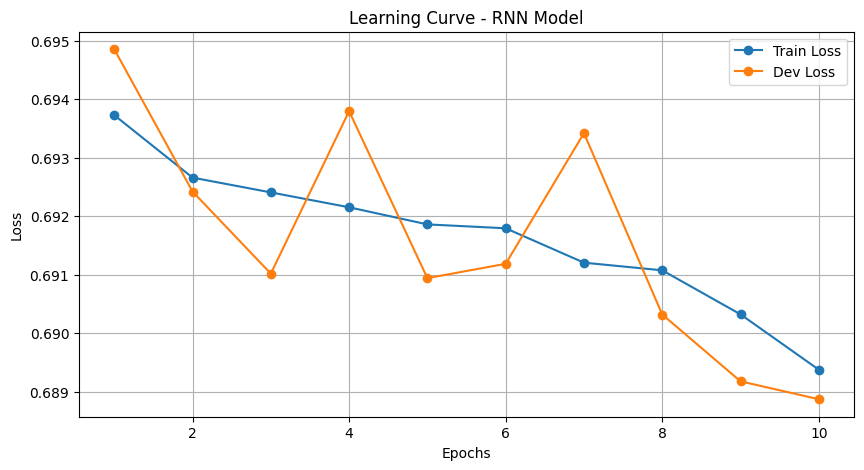

In [9]:
# Εκπαίδευση RNN
rnn_model = RNNModel()
train_losses, dev_losses = train_rnn(rnn_model, train_loader, dev_loader, epochs=10)

# ---- ΣΥΓΚΡΙΣΗ ΜΕ RANDOM FOREST ----
rf_sklearn = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_sklearn.fit(x_train, y_train)
y_pred_sklearn = rf_sklearn.predict(x_test)

# Αξιολόγηση Μοντέλου
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    print(f"{model_name} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")

# Αξιολόγηση RNN
rnn_model.eval()
rnn_preds, rnn_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = rnn_model(inputs).squeeze()
        rnn_preds.extend(outputs.cpu().numpy())
        rnn_labels.extend(labels.cpu().numpy())

rnn_preds = (np.array(rnn_preds) > 0.5).astype(int)

# Αποτελέσματα
print("\nScikit-learn Random Forest")
evaluate_model(y_test, y_pred_sklearn, "Scikit-learn RF")

print("\nRNN Model")
evaluate_model(rnn_labels, rnn_preds, "RNN Model")

# ---- ΚΑΜΠΥΛΕΣ ΜΑΘΗΣΗΣ ----
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, 11), dev_losses, marker='o', label='Dev Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - RNN Model")
plt.legend()
plt.grid()
plt.show()
